# Deep RNNs

## First Using a simple RNN

In [1]:
import tensorflow as tf
import pandas as pd

from pathlib import Path

2023-11-28 16:42:35.239522: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 16:42:35.323299: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 16:42:37.043174: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
# 将数据框的列名更改为较短的形式，以提高代码的可读性。
df.columns = ["date", "day_type", "bus", "rail", "total"]
# 根据日期列对数据框进行排序，并将日期列设置为数据框的索引。
df = df.sort_values("date").set_index("date")
# no need for total, it's just bus + rail
df = df.drop("total", axis=1)
# remove duplicated months (2011-10 and 2014-07)
df = df.drop_duplicates()

rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06"]

seq_length = 56
tf.random.set_seed(42)
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [3]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

解释下这段代码：  
1. `model = tf.keras.Sequential([...])`: 创建一个顺序模型。
2. `tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])`: 向模型中添加一个简单的循环神经网络层。具体参数解释如下：
    * 1: 表示该 RNN 层中的神经元数量为 1。
    * input_shape=[None, 1]: 指定输入序列的形状。这里表示输入序列的长度可以是任意值（None），每个时间步有一个特征（1维）。

In [4]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [5]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 2s 21ms/step - loss: 0.1349 - mae: 0.3937 - val_loss: 0.0741 - val_mae: 0.3434
Epoch 2/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0590 - mae: 0.2941 - val_loss: 0.0517 - val_mae: 0.2721
Epoch 3/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0279 - mae: 0.1707 - val_loss: 0.0152 - val_mae: 0.1261
Epoch 4/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0147 - mae: 0.1563 - val_loss: 0.0139 - val_mae: 0.1377
Epoch 5/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0142 - mae: 0.1498 - val_loss: 0.0139 - val_mae: 0.1348
Epoch 6/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0140 - mae: 0.1500 - val_loss: 0.0138 - val_mae: 0.1332
Epoch 7/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0139 - mae: 0.1481 - val_loss: 0.0136 - val_mae: 0.1328
Epoch 8/500
33/33 [==============================] - 0s 12ms/step - loss: 0.

102811.00869178772

In [63]:
# 102811.00869178772

## Deep RNNs

### 单层 SimpleRNN 和多层 SimpleRNN

In [6]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

这样的模型结构适用于单变量时间序列的预测任务，其中每个时间步的输入是一个标量（1维特征），模型通过 RNN 层学习时间序列中的模式，并通过最后的密集连接层生成预测值。  
1. `tf.keras.layers.SimpleRNN(32, input_shape=[None, 1])`: 向模型中添加一个简单的循环神经网络（RNN）层。具体参数解释如下：
    * 32: 表示 RNN 层中的神经元数量为 32。
    * input_shape=[None, 1]: 指定输入序列的形状。这里表示输入序列的长度可以是任意值（None），每个时间步有一个特征（1维）。
2. `tf.keras.layers.Dense(1)`: 向模型中添加一个密集连接层（全连接层），具有一个神经元。在此层中，默认情况下没有激活函数。

In [7]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)  # return 29473

Epoch 1/500
33/33 [==============================] - 2s 20ms/step - loss: 0.0144 - mae: 0.1306 - val_loss: 0.0057 - val_mae: 0.0859
Epoch 2/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0045 - mae: 0.0645 - val_loss: 0.0025 - val_mae: 0.0484
Epoch 3/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0034 - mae: 0.0524 - val_loss: 0.0021 - val_mae: 0.0378
Epoch 4/500
33/33 [==============================] - 0s 14ms/step - loss: 0.0034 - mae: 0.0527 - val_loss: 0.0023 - val_mae: 0.0419
Epoch 5/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0031 - mae: 0.0500 - val_loss: 0.0019 - val_mae: 0.0345
Epoch 6/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0032 - mae: 0.0542 - val_loss: 0.0020 - val_mae: 0.0361
Epoch 7/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0034 - mae: 0.0539 - val_loss: 0.0022 - val_mae: 0.0372
Epoch 8/500
33/33 [==============================] - 1s 17ms/step - loss: 0.

31252.723187208176

In [8]:
tf.random.set_seed(42)
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

这部分定义了一个深层次的时间序列模型 deep_model。具体解释如下：
1. tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]): 添加一个 SimpleRNN 层，返回完整的输出序列（return_sequences=True），并指定输入序列的形状。

2. tf.keras.layers.SimpleRNN(32, return_sequences=True): 添加第二个 SimpleRNN 层，同样返回完整的输出序列。

3. tf.keras.layers.SimpleRNN(32): 添加第三个 SimpleRNN 层，不再返回完整的输出序列，而只返回最后一个时间步的输出。

4. tf.keras.layers.Dense(1): 添加一个密集连接层，用于生成最终的预测结果。

In [9]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)  # return 30165

Epoch 1/500
33/33 [==============================] - 4s 49ms/step - loss: 0.0336 - mae: 0.1599 - val_loss: 0.0044 - val_mae: 0.0792
Epoch 2/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0067 - mae: 0.0884 - val_loss: 0.0032 - val_mae: 0.0625
Epoch 3/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0063 - mae: 0.0842 - val_loss: 0.0027 - val_mae: 0.0522
Epoch 4/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0047 - mae: 0.0675 - val_loss: 0.0038 - val_mae: 0.0665
Epoch 5/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0042 - mae: 0.0603 - val_loss: 0.0044 - val_mae: 0.0736
Epoch 6/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0043 - mae: 0.0622 - val_loss: 0.0024 - val_mae: 0.0446
Epoch 7/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0041 - mae: 0.0600 - val_loss: 0.0032 - val_mae: 0.0607
Epoch 8/500
33/33 [==============================] - 1s 36ms/step - loss: 0.

29806.658625602722

### 多变量时间序列 Multivariate time series

In [28]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

df_mulvar["next_day_type_A"] = df_mulvar["next_day_type_A"].astype(int)
df_mulvar["next_day_type_U"] = df_mulvar["next_day_type_U"].astype(int)
df_mulvar["next_day_type_W"] = df_mulvar["next_day_type_W"].astype(int)

数据处理解释：
1. df_mulvar["next_day_type"] = df["day_type"].shift(-1): 创建一个新列 "next_day_type"，其中包含 "day_type" 列的明天的值。通过使用 shift(-1) 方法，将 "day_type" 向上偏移一天。

2. df_mulvar = pd.get_dummies(df_mulvar): 对 "day_type" 进行独热编码，将其转换成三个二元特征列，分别代表 "A"、"U"、"W" 三个类别。

In [29]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [30]:
tf.random.set_seed(42)

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [31]:
tf.random.set_seed(42)
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

这段代码涉及到多变量时间序列数据的建模和训练，具体解释如下：

1. `train_mulvar_ds`: 使用 `timeseries_dataset_from_array` 函数创建训练数据集，将 `mulvar_train.to_numpy()` 的所有 5 列作为输入。`targets` 参数指定了要预测的目标变量，这里是 "rail" 列，同时也指定了 `sequence_length`、`batch_size` 等参数。

2. `valid_mulvar_ds`: 类似地，使用相同的函数创建验证数据集，`targets` 也是 "rail" 列。

3. `mulvar_model`: 创建了一个顺序模型，包含一个 SimpleRNN 层和一个 Dense 层。SimpleRNN 层的 `input_shape=[None, 5]` 表示输入序列的长度可以是任意值，每个时间步有 5 个特征。

这段代码的目的是利用多变量时间序列数据，以 "bus"、"rail" 等多个变量作为输入，预测下一个时间步的 "rail" 列。

In [32]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds, learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 2s 19ms/step - loss: 0.0360 - mae: 0.1767 - val_loss: 0.0016 - val_mae: 0.0413
Epoch 2/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0033 - mae: 0.0630 - val_loss: 0.0012 - val_mae: 0.0353
Epoch 3/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0016 - mae: 0.0388 - val_loss: 0.0011 - val_mae: 0.0366
Epoch 4/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0016 - mae: 0.0410 - val_loss: 7.5276e-04 - val_mae: 0.0292
Epoch 5/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0015 - mae: 0.0387 - val_loss: 0.0013 - val_mae: 0.0425
Epoch 6/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0014 - mae: 0.0374 - val_loss: 8.9067e-04 - val_mae: 0.0331
Epoch 7/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0014 - mae: 0.0366 - val_loss: 7.1662e-04 - val_mae: 0.0269
Epoch 8/500
33/33 [==============================] - 0s 13ms/ste

22907.99468755722

### 多任务 RNN

In [33]:
# extra code – build and train a multitask RNN that forecasts both bus and rail

tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 2s 23ms/step - loss: 0.0744 - mae: 0.2664 - val_loss: 0.0078 - val_mae: 0.1089
Epoch 2/500
33/33 [==============================] - 1s 15ms/step - loss: 0.0041 - mae: 0.0657 - val_loss: 0.0019 - val_mae: 0.0494
Epoch 3/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0025 - mae: 0.0481 - val_loss: 0.0011 - val_mae: 0.0348
Epoch 4/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0022 - mae: 0.0454 - val_loss: 0.0019 - val_mae: 0.0508
Epoch 5/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0021 - mae: 0.0445 - val_loss: 0.0012 - val_mae: 0.0372
Epoch 6/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0020 - mae: 0.0427 - val_loss: 0.0010 - val_mae: 0.0341
Epoch 7/500
33/33 [==============================] - 1s 15ms/step - loss: 0.0019 - mae: 0.0418 - val_loss: 0.0010 - val_mae: 0.0351
Epoch 8/500
33/33 [==============================] - 0s 13ms/step - loss: 0.

26092.7751660347

26092  
这段代码的目的是构建一个可以同时预测 "bus" 和 "rail" 列的多任务模型，并使用多任务数据集进行训练和评估。

1. train_multask_ds: 使用 timeseries_dataset_from_array 函数创建多任务训练数据集。targets 参数指定了要预测的目标变量，这里是 "bus" 和 "rail" 列，每天有两个目标。

2. valid_multask_ds: 类似地，使用相同的函数创建验证数据集。

3. multask_model: 创建了一个顺序模型，包含一个 SimpleRNN 层和一个 Dense 层。SimpleRNN 层的 input_shape=[None, 5] 表示输入序列的长度可以是任意值，每个时间步有 5 个特征。Dense 层有 2 个神经元，因为我们有两个目标变量。

In [36]:
# evaluates the naive forecasts for bus
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

43441.63157894738

这段代码计算了"bus"列的简单滞后（naive）预测的平均绝对误差（Mean Absolute Error，MAE）。具体解释如下：

1. bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]: 创建了一个简单滞后（naive）预测的 "bus" 列。通过使用 shift(7) 将时间序列向后移动 7 天，即使用过去一周的数据作为预测。

2. bus_target = mulvar_valid["bus"][seq_length:]: 选取验证集中 "bus" 列的真实值，确保从同一时间步开始，保持与 bus_naive 对齐。

3. (bus_target - bus_naive).abs().mean() * 1e6: 计算滞后预测的平均绝对误差。首先，通过 (bus_target - bus_naive) 得到每个时间步的预测误差，然后使用 .abs() 计算绝对值，最后使用 .mean() 计算平均值。

这个操作的目的是评估在使用简单滞后预测的情况下，模型在 "bus" 列上的表现。如果误差很小，说明简单滞后方法在这个时间序列上可能是有效的。

In [37]:
# evaluates the multitask RNN's forecasts both bus and rail
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.mean_absolute_error(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, int(mae))

3/3 [==============================] - 0s 6ms/step
bus 26630
rail 25554


评估多任务 RNN 模型对 "bus" 和 "rail" 列的预测性能

### Forecasting Several Steps Ahead 
使用单变量RNN模型进行未来时间步预测

In [40]:
import numpy as np
import matplotlib.pyplot as plt

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 26ms/step


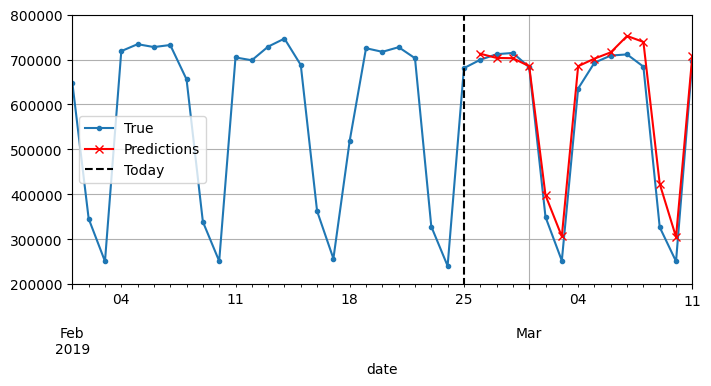

In [43]:
# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end on 2019-03-31. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0], index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
plt.show()

上述代码通过单变量 RNN 模型对未来时间步进行预测，并将预测结果与真实值进行对比。

### 使用多变量时间序列数据进行未来时间步预测
Now let's create an RNN that predicts all 14 next values at once:

In [45]:
tf.random.set_seed(42)

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [46]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [47]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 2s 21ms/step - loss: 0.0767 - mae: 0.2918 - val_loss: 0.0279 - val_mae: 0.1862
Epoch 2/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0214 - mae: 0.1646 - val_loss: 0.0163 - val_mae: 0.1380
Epoch 3/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0153 - mae: 0.1385 - val_loss: 0.0121 - val_mae: 0.1210
Epoch 4/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0125 - mae: 0.1243 - val_loss: 0.0099 - val_mae: 0.1088
Epoch 5/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0107 - mae: 0.1139 - val_loss: 0.0086 - val_mae: 0.1014
Epoch 6/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0095 - mae: 0.1060 - val_loss: 0.0071 - val_mae: 0.0921
Epoch 7/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0086 - mae: 0.0996 - val_loss: 0.0063 - val_mae: 0.0872
Epoch 8/500
33/33 [==============================] - 0s 13ms/step - loss: 0.

33953.4617960453

In [48]:
# 33953.4617960453

In [49]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

1/1 [==============================] - 0s 171ms/step


### 通过 windows 时间窗口来预测未来时间步

Now let's create an RNN that predicts the next 14 steps at each time step. That is, instead of just forecasting time steps 56 to 69 based on time steps 0 to 55, it will forecast time steps 1 to 14 at time step 0, then time steps 2 to 15 at time step 1, and so on, and finally it will forecast time steps 56 to 69 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

To prepare the datasets, we can use `to_windows()` twice, to get sequences of consecutive windows, like this:

In [52]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [53]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

Then we can split these elements into the desired inputs and targets:

In [54]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

Let's wrap this idea into a utility function. It will also take care of shuffling (optional) and batching:

In [56]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                      batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds,seq_length).map(lambda S:(S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [57]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [58]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

In [59]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500
33/33 [==============================] - 3s 45ms/step - loss: 0.0465 - mae: 0.2230 - val_loss: 0.0135 - val_mae: 0.1272
Epoch 2/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0109 - mae: 0.1130 - val_loss: 0.0096 - val_mae: 0.1017
Epoch 3/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0084 - mae: 0.0970 - val_loss: 0.0081 - val_mae: 0.0916
Epoch 4/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0071 - mae: 0.0867 - val_loss: 0.0072 - val_mae: 0.0845
Epoch 5/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0061 - mae: 0.0784 - val_loss: 0.0058 - val_mae: 0.0742
Epoch 6/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0056 - mae: 0.0734 - val_loss: 0.0060 - val_mae: 0.0749
Epoch 7/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0052 - mae: 0.0695 - val_loss: 0.0054 - val_mae: 0.0695
Epoch 8/500
33/33 [==============================] - 1s 16ms/step - loss: 0.

45762.94124126434

In [60]:
# 45762.94124126434

In [61]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output

1/1 [==============================] - 0s 203ms/step


In [62]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

3/3 [==============================] - 0s 16ms/step
MAE for +1: 24,469
MAE for +2: 29,069
MAE for +3: 29,081
MAE for +4: 30,855
MAE for +5: 32,694
MAE for +6: 33,788
MAE for +7: 32,946
MAE for +8: 34,636
MAE for +9: 33,487
MAE for +10: 33,542
MAE for +11: 37,626
MAE for +12: 36,927
MAE for +13: 35,697
MAE for +14: 33,981


## Deep RNNs with Layer Norm

In [ ]:
# class LNSimpleRNNCell(tf.keras.layers.Layer):
#     def __init__(self, units, activation="tanh", **kwargs):
#         super().__init__(**kwargs)
#         self.state_size = units
#         self.output_size = units
#         self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
#         self.layer_norm = tf.keras.layers.LayerNormalization()
#         self.activation = tf.keras.activations.get(activation)
    
#     def call(self, inputs, states):
#         outputs, new_states = self.simple_rnn_cell(inputs, states)
#         norm_outputs = self.activation(self.layer_norm(outputs))
#         return norm_outputs, [norm_outputs]

In [ ]:
# tf.random.set_seed(42)
# custom_ln_model = tf.keras.Sequential([
#     tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
#     tf.keras.layers.Dense(14)
# ])

In [ ]:
# fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid, learning_rate=0.1, epochs=5)